In [27]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify as sq
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read RFM_Final dataset
df = pd.read_csv('./datasets/1_SEGMENTATION/RFM_Final.csv')
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,CLV
0,AA00312188,487,102,102182.25,0,11761.28
1,AA00312390,268,58,36476.70,0,5153.43
2,AA00325975,268,205,282986.00,200,20385.07
3,AA00336843,354,69,33192.50,138,2728.84
4,AA00339761,346,59,32488.30,0,7703.97


In [4]:
# Create a copy dataset with the same index as the original dataset to avoid any issues when merging the datasets
df_copy = df.copy()

In [5]:
df_copy.columns

Index(['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary', 'L', 'CLV'], dtype='object')

In [6]:
# Drop the columns that are not needed for the clustering analysis
df_copy = df_copy.drop(['CUSTOMER_ID'], axis=1)

# Check the columns that are left in the dataset
df_copy.columns

Index(['Recency', 'Frequency', 'Monetary', 'L', 'CLV'], dtype='object')

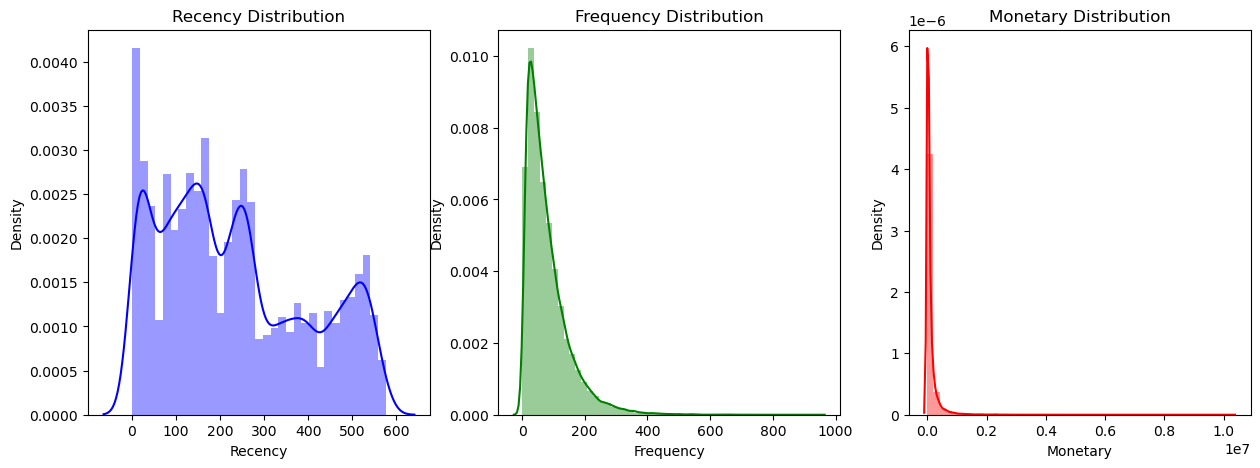

In [14]:
# Plot the distribution of the data
plt.figure(figsize=(15, 5))

# Plot subplots for Recency, Frequency and Monetary
plt.subplot(1, 3, 1)
sns.distplot(df_copy['Recency'], color='blue')
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.distplot(df_copy['Frequency'], color='green')
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.distplot(df_copy['Monetary'], color='red')
plt.title('Monetary Distribution')

plt.show()

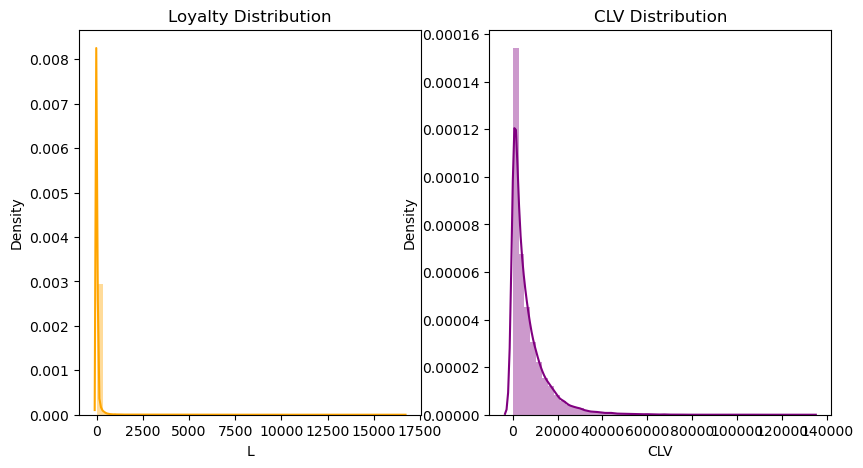

In [13]:
# Plot the distribution of the data
plt.figure(figsize=(15, 5))

# Plot subplots for L and CLV
plt.subplot(1, 3, 1)
sns.distplot(df_copy['L'], color='orange')
plt.title('Loyalty Distribution')

plt.subplot(1, 3, 2)
sns.distplot(df_copy['CLV'], color='purple')
plt.title('CLV Distribution')

plt.show()

- The data from is mostly skewed heavily to the left.
- The skeweness must be eliminated before proceeding

In [19]:
# Removal of skewness
recency_log = np.log1p(df_copy['Recency']).round(2)
frequency_log = np.log1p(df_copy['Frequency']).round(2)
monetary_log = np.log1p(df_copy['Monetary']).round(2)
loyalty_log = np.log1p(df_copy['L']).round(2)
clv_log = np.log1p(df_copy['CLV']).round(2)

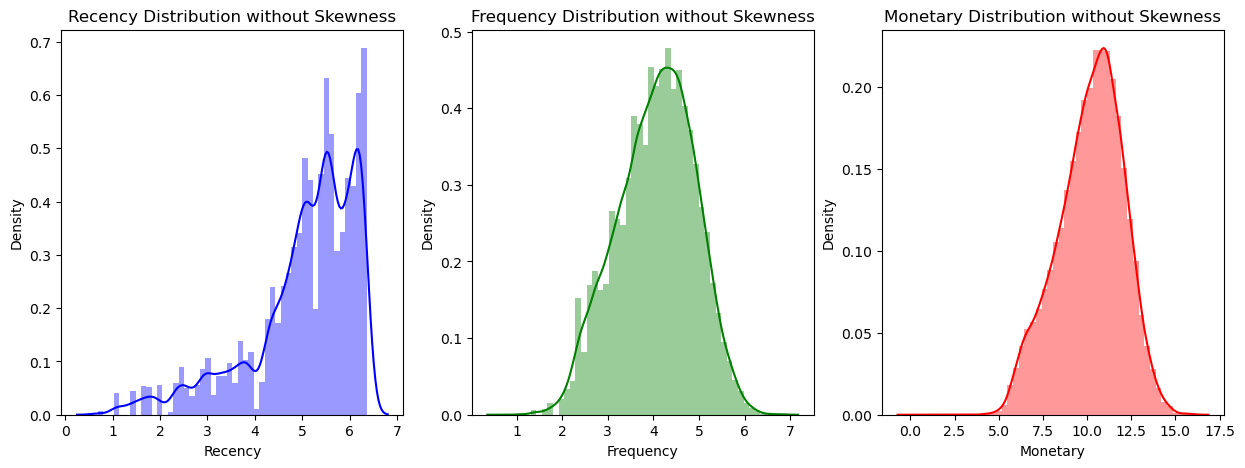

In [20]:
# Plot the distribution of the data
plt.figure(figsize=(15, 5))

# Plot subplots for Recency, Frequency and Monetary
plt.subplot(1, 3, 1)
sns.distplot(recency_log, color='blue')
plt.title('Recency Distribution without Skewness')

plt.subplot(1, 3, 2)
sns.distplot(frequency_log, color='green')
plt.title('Frequency Distribution without Skewness')

plt.subplot(1, 3, 3)
sns.distplot(monetary_log, color='red')
plt.title('Monetary Distribution without Skewness')

plt.show()

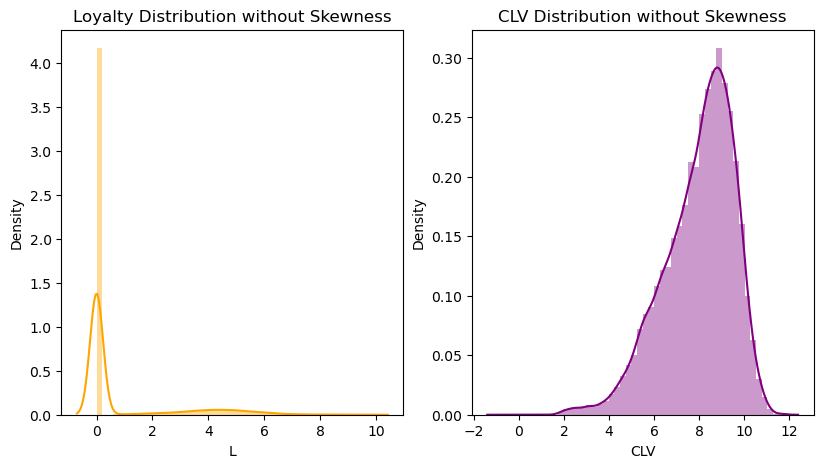

In [21]:
# Plot the distribution of the data
plt.figure(figsize=(15, 5))

# Plot subplots for L and CLV
plt.subplot(1, 3, 1)
sns.distplot(loyalty_log, color='orange')
plt.title('Loyalty Distribution without Skewness')

plt.subplot(1, 3, 2)
sns.distplot(clv_log, color='purple')
plt.title('CLV Distribution without Skewness')

plt.show()

In [22]:
# Create new dataframe with the unskewed data
df_ = pd.DataFrame({'Recency': recency_log, 'Frequency': frequency_log, 'Monetary': monetary_log, 'Loyalty': loyalty_log, 'CLV': clv_log})
df_.head()

,Recency,Frequency,Monetary,Loyalty,CLV
0,6.19,4.63,11.53,0.00,9.37
1,5.59,4.08,10.50,0.00,8.55
2,5.59,5.33,12.55,5.30,9.92
3,5.87,4.25,10.41,4.93,7.91
4,5.85,4.09,10.39,0.00,8.95


In [23]:
scaler_rfm = StandardScaler()
scaler_rfm.fit(df_)

# Standardizing the data
rfm_standardized = scaler_rfm.transform(df_)

print('mean:', rfm_standardized.mean(axis=0).round(2))
print('std:', rfm_standardized.std(axis=0).round(2))

mean: [ 0. -0. -0. -0. -0.]
std: [1. 1. 1. 1. 1.]


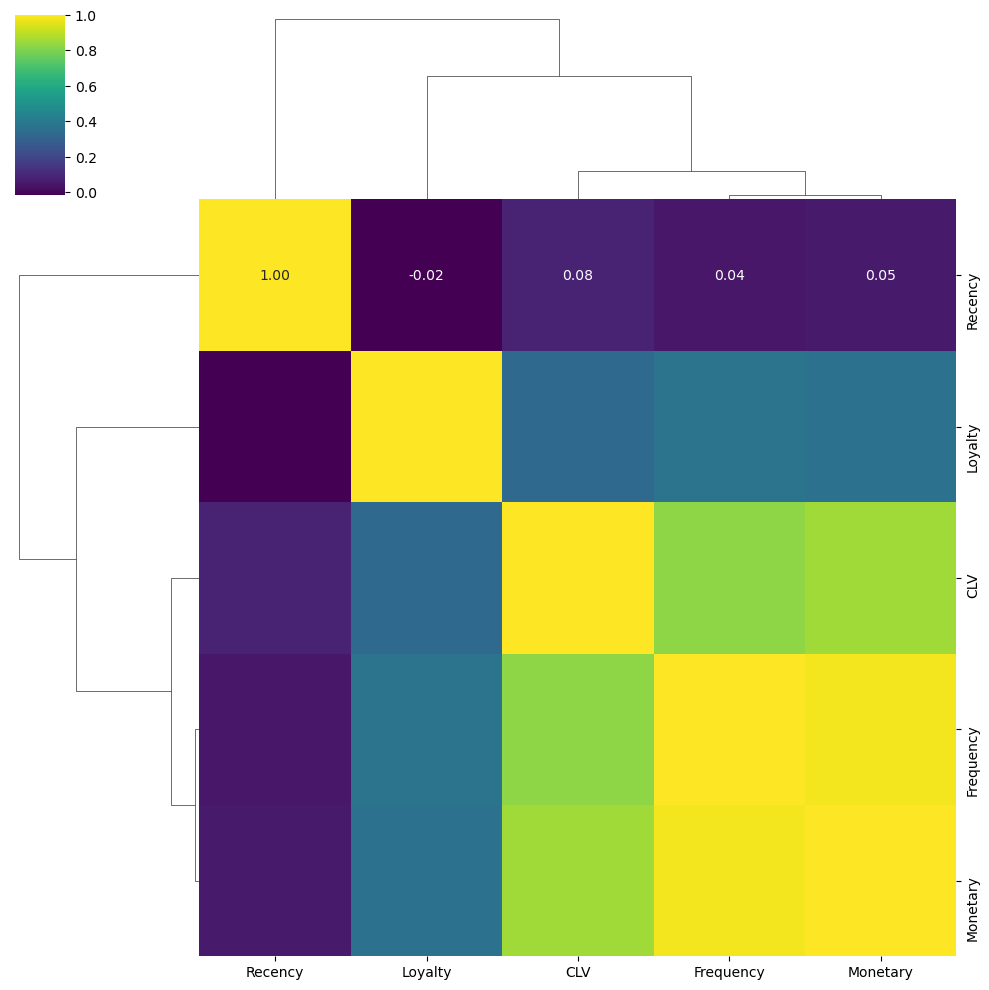

In [24]:
# Clustermap of df_ data
sns.clustermap(df_.corr(), cmap='viridis', annot=True, fmt=".2f")

Number of clusters: 2
Inertia score: [78209.74536738072]
Silhouette score (euc): 0.34
Silhouette score (cos): 0.55
Silhouette score (man): 0.4
Davies Bouldin Score: 1.1
Calinski-Harabasz Score: [16586.13452463244]
---------------------------------
Number of clusters: 3
Inertia score: [78209.74536738072, 57460.343529179314]
Silhouette score (euc): 0.36
Silhouette score (cos): 0.49
Silhouette score (man): 0.38
Davies Bouldin Score: 1.03
Calinski-Harabasz Score: [16586.13452463244, 15931.991221573884]
---------------------------------
Number of clusters: 4
Inertia score: [78209.74536738072, 57460.343529179314, 46698.91425844707]
Silhouette score (euc): 0.37
Silhouette score (cos): 0.5
Silhouette score (man): 0.36
Davies Bouldin Score: 0.96
Calinski-Harabasz Score: [16586.13452463244, 15931.991221573884, 15044.274677256251]
---------------------------------
Number of clusters: 5
Inertia score: [78209.74536738072, 57460.343529179314, 46698.91425844707, 37118.76343535661]
Silhouette score (e

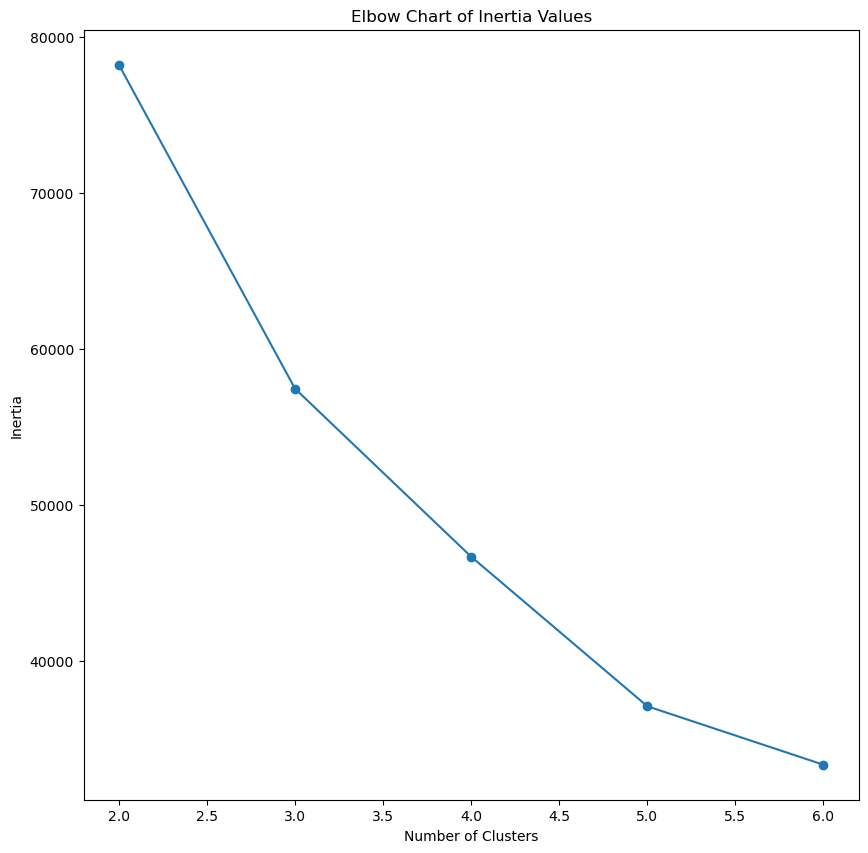

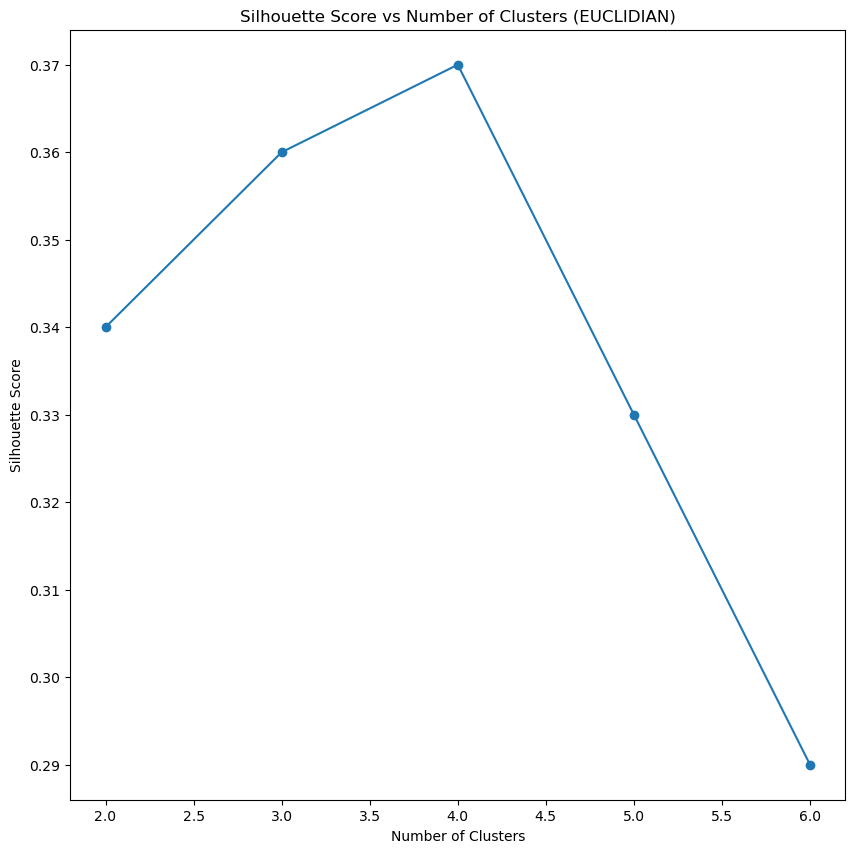

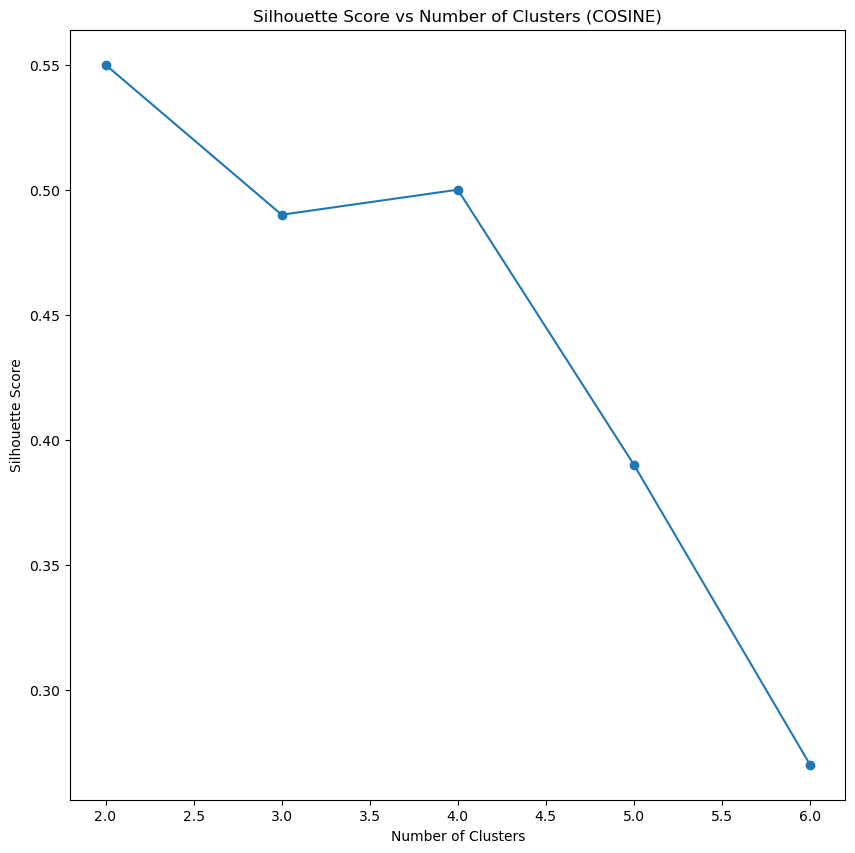

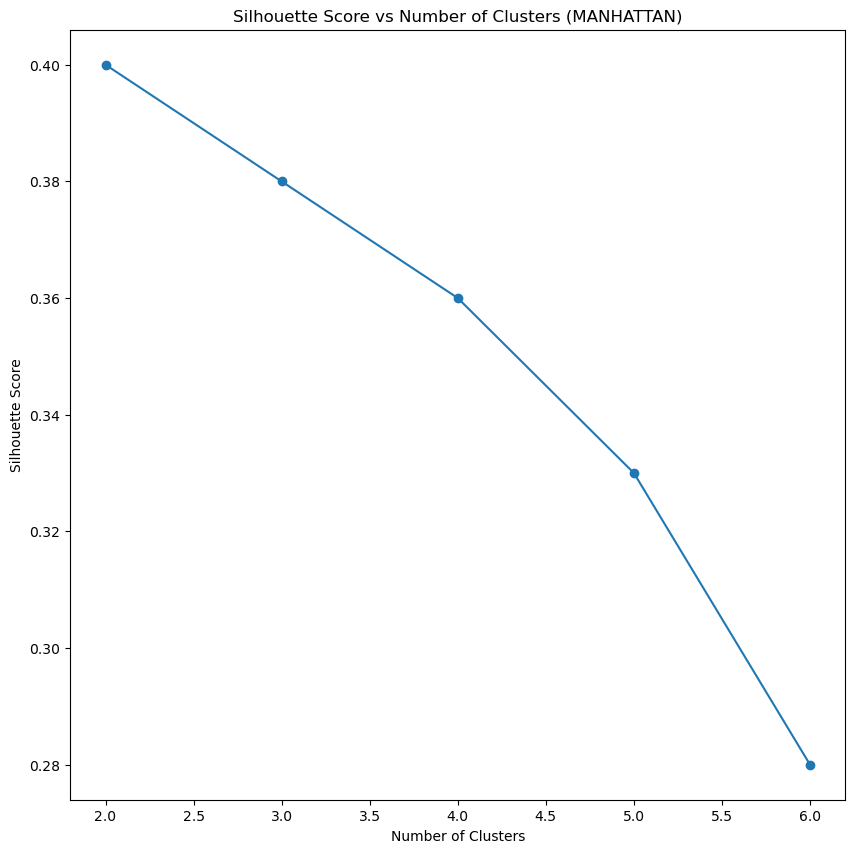

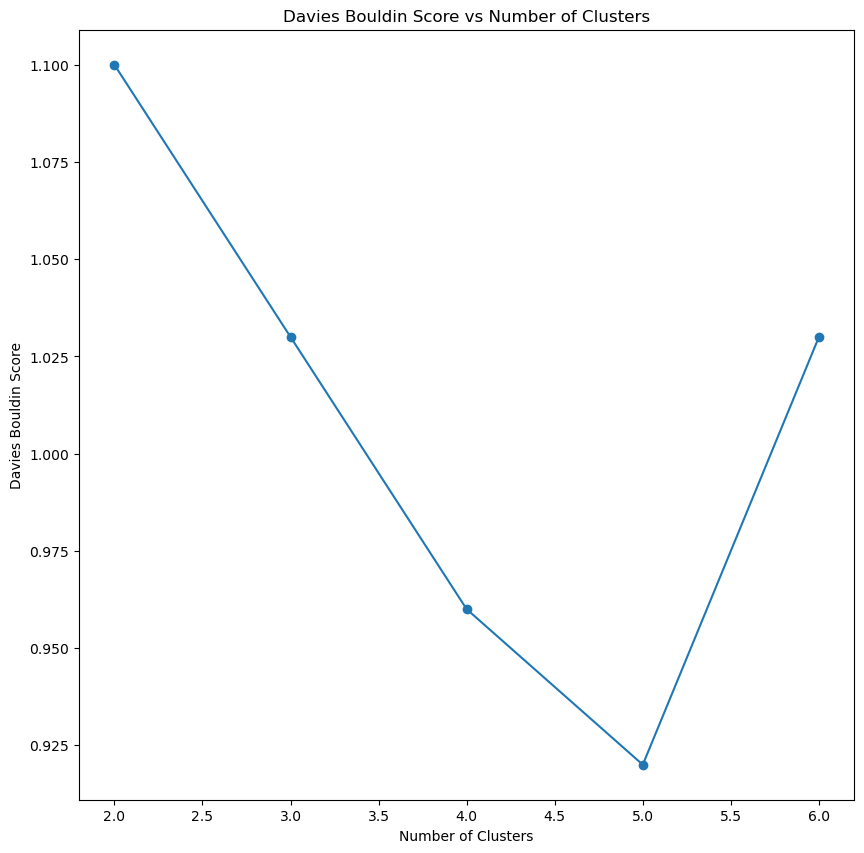

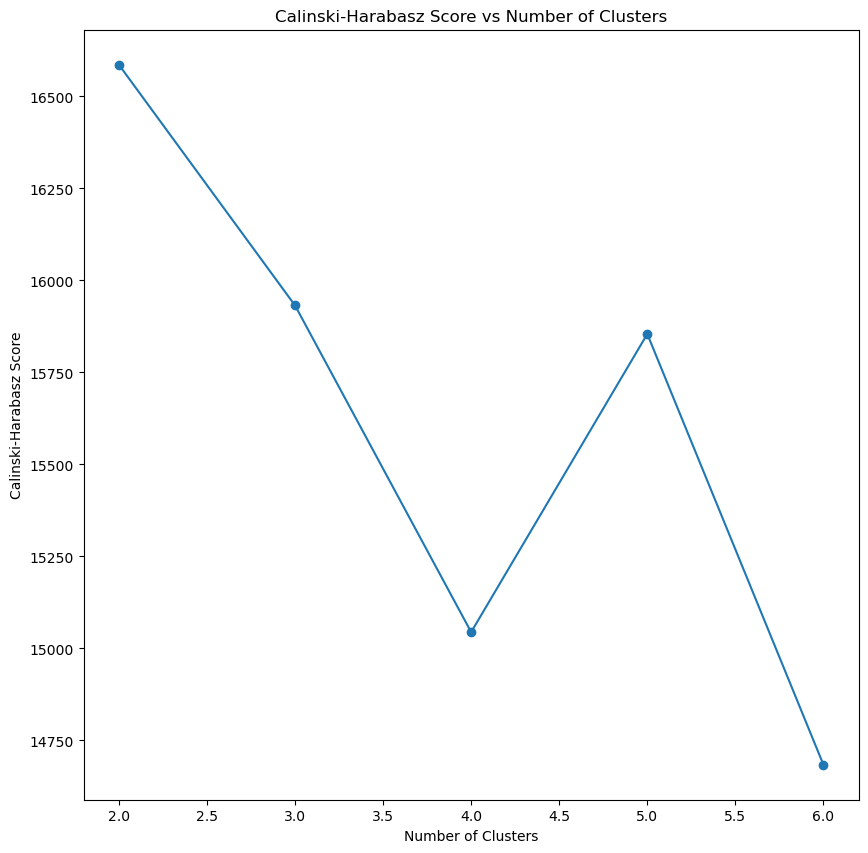

In [60]:
# KMeans Clustering
# Inertia
inertia = []

# Define a list to store the silhouette scores
silhouette_scores = []
silhouette_scores_cosine = []
silhouette_scores_manhattan = []

# Define a list to store the Davies Bouldin scores
davies_bouldin_scores = []

# Define a list to store the Calinski-Harabasz scores
CH_scores = []

# Create a range of K values
k_values = range(2, 7)

# Loop through the K values
for k in k_values:
    # Create a KMeans object
    kmeans = KMeans(n_clusters=k, random_state=1)
    # Fit the KMeans object to the PCA data
    kmeans.fit(rfm_standardized)

    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

    # Cluster labels
    cluster_labels = kmeans.labels_
    df['Cluster'] = kmeans.labels_

    # Calculate the silhouette score - euclidean distance
    silhouette_score = metrics.silhouette_score(rfm_standardized, cluster_labels, metric='euclidean').round(2)
    silhouette_scores.append(silhouette_score)

    # Calculate the silhouette score - cosine distance
    silhouette_score_cosine = metrics.silhouette_score(rfm_standardized, cluster_labels, metric='cosine').round(2)
    silhouette_scores_cosine.append(silhouette_score_cosine)

    # Calculate the silhouette score - manhattan distance
    silhouette_score_manhattan = metrics.silhouette_score(rfm_standardized, cluster_labels, metric='manhattan').round(2)
    silhouette_scores_manhattan.append(silhouette_score_manhattan)

    # Calculate the Davies Bouldin score
    davies_bouldin_score = metrics.davies_bouldin_score(rfm_standardized, cluster_labels).round(2)
    davies_bouldin_scores.append(davies_bouldin_score)

    # Calculate the Calinski-Harabasz score
    CH_score = calinski_harabasz_score(rfm_standardized, cluster_labels)
    CH_scores.append(CH_score)

    # Print the silhouette score and Davies Bouldin score for the current number of clusters
    print("Number of clusters: {}".format(k))
    print("Inertia score: {}".format(inertia))
    print("Silhouette score (euc): {}".format(silhouette_score))
    print("Silhouette score (cos): {}".format(silhouette_score_cosine))
    print("Silhouette score (man): {}".format(silhouette_score_manhattan))
    print("Davies Bouldin Score: {}".format(davies_bouldin_score))
    print("Calinski-Harabasz Score: {}".format(CH_scores))
    print("---------------------------------")

# Plot the inertia values
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Chart of Inertia Values')
plt.plot(k_values, inertia, marker='o')

# Plot the silhouette scores - euclidian
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (EUCLIDIAN)')
plt.plot(k_values, silhouette_scores, marker='o')

# Plot the silhouette scores - cosine
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (COSINE)')
plt.plot(k_values, silhouette_scores_cosine, marker='o')

# Plot the silhouette scores - manhattan
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (MANHATTAN)')
plt.plot(k_values, silhouette_scores_manhattan, marker='o')

# Plot the Davies Bouldin scores
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score vs Number of Clusters')
plt.plot(k_values, davies_bouldin_scores, marker='o')

# Plot the Calinski-Harabasz score
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.plot(k_values, CH_scores, marker='o')

In [61]:
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,CLV,Cluster_Agglomerative,Cluster
0,AA00312188,487,102,102182.25,0,11761.28,4,2
1,AA00312390,268,58,36476.70,0,5153.43,1,4
2,AA00325975,268,205,282986.00,200,20385.07,2,1
3,AA00336843,354,69,33192.50,138,2728.84,2,1
4,AA00339761,346,59,32488.30,0,7703.97,1,4


In [111]:
# Selection of the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(rfm_standardized)
df['Cluster'] = kmeans.labels_

# Calculate the average RFM values and size for each cluster
cluster_avg = df.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
    'L': 'mean',
    'CLV': 'mean'
}).round(0)

In [93]:
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,CLV,Cluster_Agglomerative,Cluster
0,AA00312188,487,102,102182.25,0,11761.28,4,3
1,AA00312390,268,58,36476.70,0,5153.43,1,3
2,AA00325975,268,205,282986.00,200,20385.07,2,1
3,AA00336843,354,69,33192.50,138,2728.84,2,1
4,AA00339761,346,59,32488.30,0,7703.97,1,3


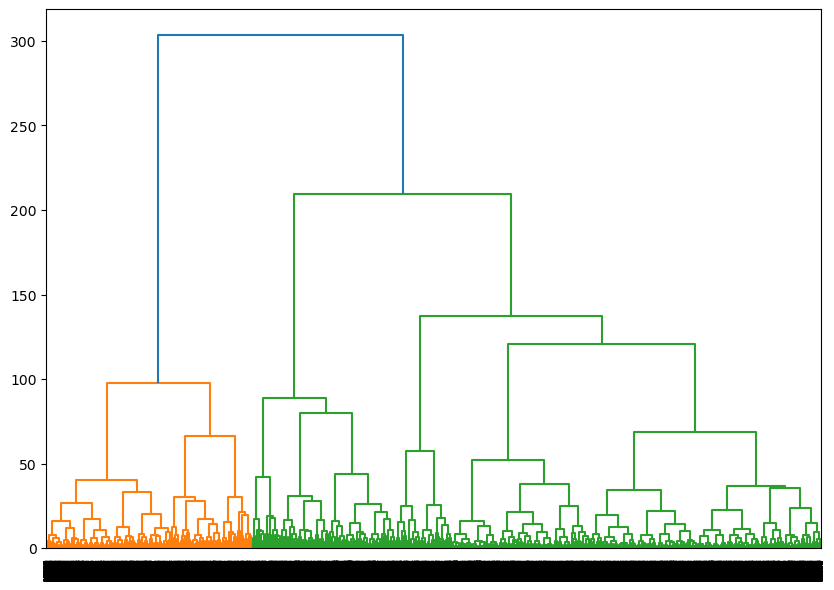

In [40]:
# Fit the hierarchical clustering to the dataset
linked = linkage(rfm_standardized, 'ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort=True, show_leaf_counts=True)

# Visualize the dendrogram
plt.show()

In [110]:
# Create an Agglomerative Clustering object
agg_clustering = AgglomerativeClustering(n_clusters=5)

# Fit the object to the data
agg_clustering.fit(rfm_standardized)

# Assign the clusters to the data
df['Cluster_Agglomerative'] = agg_clustering.labels_

# Calculate the average RFM values and size for each cluster
alg_cluster_avg = df.groupby(['Cluster_Agglomerative']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
    'L': 'mean',
    'CLV': 'mean'
}).round(0)

         Recency  Frequency  Monetary     L  CLV
Cluster                                         
0          -1.00      -1.01      -1.0 -1.01 -1.0
1          -1.00      -0.99      -1.0 -0.94 -1.0
2          -1.01      -1.00      -1.0 -1.00 -1.0
3          -1.00      -0.99      -1.0 -1.01 -1.0


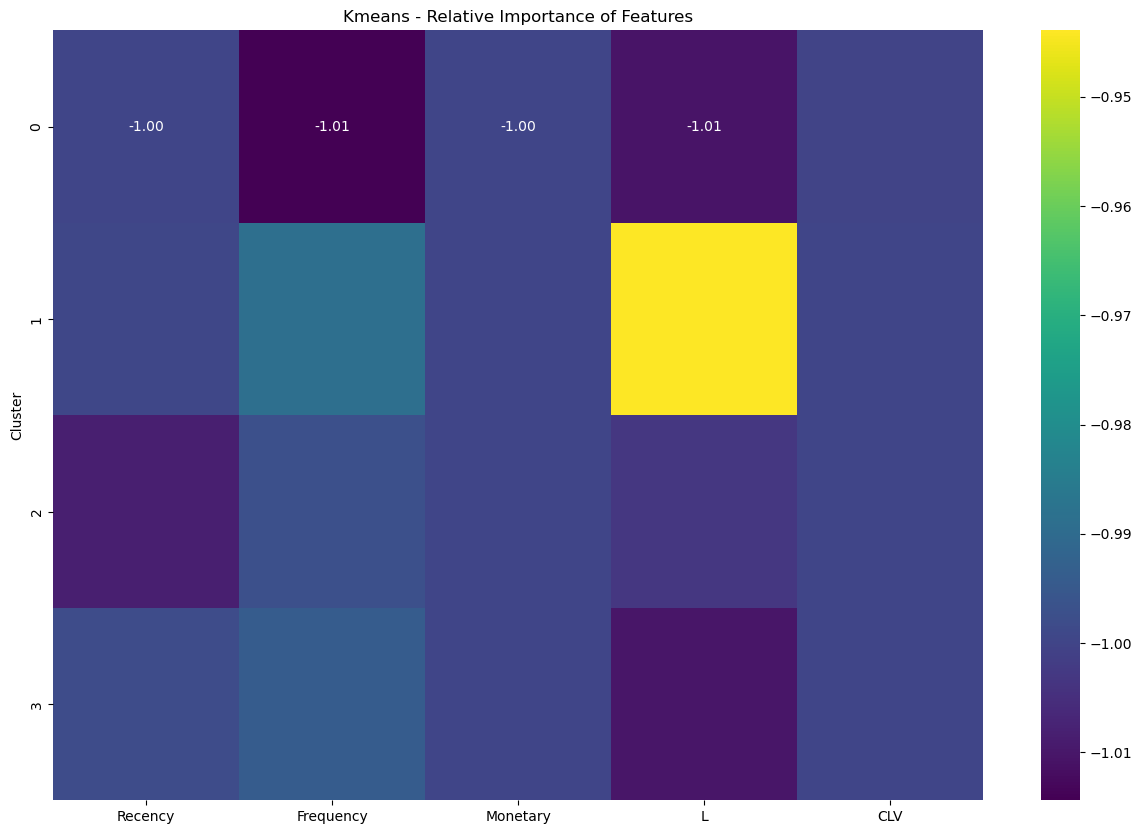

In [95]:
# Relative Importance Score:
# The relative importance score is a way to identify the most important features in a clustering analysis.
# The closer the score is to 0, the less important the feature is to the cluster.
df_norm_kmeans = pd.DataFrame(rfm_standardized, columns=df_copy.columns, index=df_copy.index)
df_norm_kmeans['Cluster'] = df['Cluster']

kmeans_avg = df_norm_kmeans.groupby(['Cluster']).mean()
kmeans_pop_avg = df_copy.mean()
relative_importance = kmeans_avg / kmeans_pop_avg - 1

print(relative_importance.round(2))

plt.figure(figsize=(15, 10))
sns.heatmap(relative_importance, annot=True, fmt='.2f', cmap='viridis')
plt.title('Kmeans - Relative Importance of Features')
plt.show()

### Interpretation of Heatmap containing Kmeans Clustering and Segment Labels
- We can come up with the following labels for the different groupings:
    - `Loyal Customers` - These are denoted to have the highest RFM metrics and should be targetted with exclusive offers and reward programs to keep them loyal. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap.
    - `Recent Buyers` - These are denoted to have the high recency, moderate frequency or monetary RFM metrics, they may not be high spenders and thus should be engaged with targeted campaigns to try raise their level to loyal customers. They fall in `Cluster `, as is shown by the relative importance heatmap. 
    - `At-Risk Customers` - These are denoted to have low recency, and variable to moderate frequency and monetary RFM metrics. They need to be won back with attractive offers that consider increasing spending and/or increasing frequency of purchases. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap. 
    - `New Customers` - These are denoted to have the lowest RFM metrics and converted to repeat-buyers. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap.
 

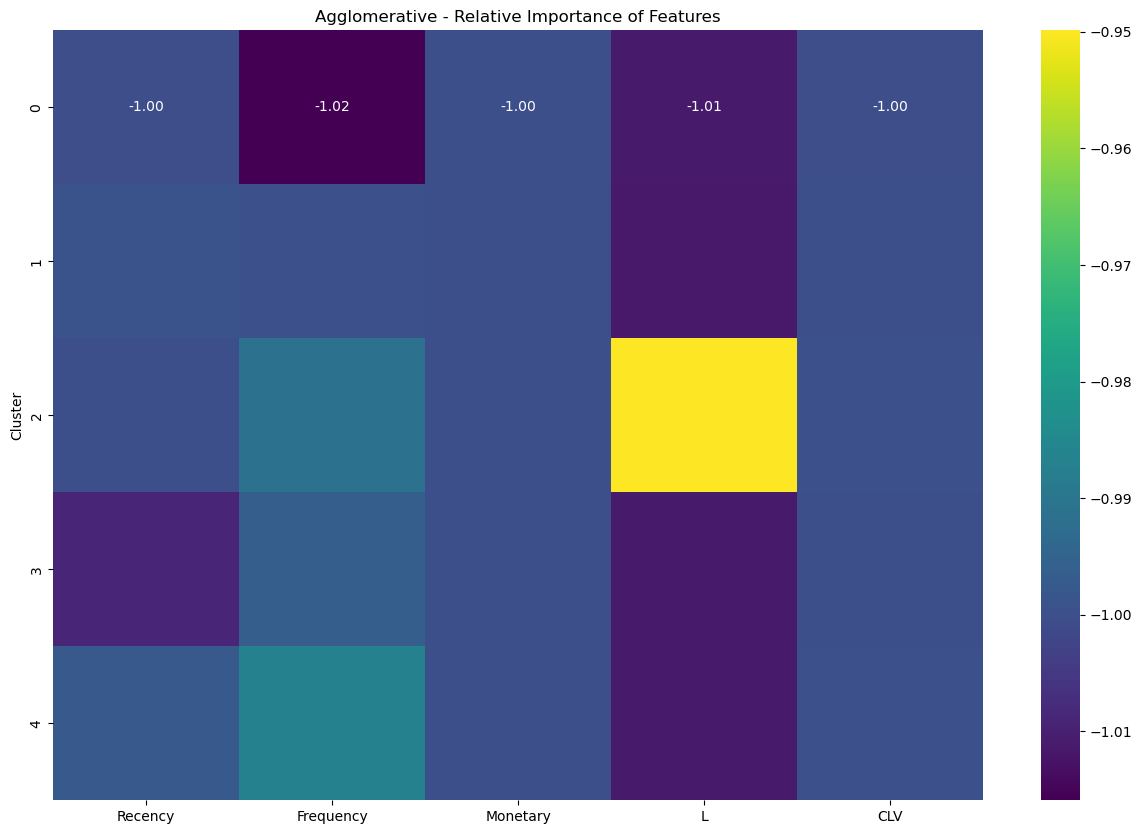

In [96]:
# Relative Importance Score:
# The relative importance score is a way to identify the most important features in a clustering analysis.
# The closer the score is to 0, the less important the feature is to the cluster.
df_norm_agg = pd.DataFrame(rfm_standardized, columns=df_copy.columns, index=df_copy.index)
df_norm_agg['Cluster'] = df['Cluster_Agglomerative']

agg_avg = df_norm_agg.groupby(['Cluster']).mean()
agg_pop_avg = df_copy.mean()
relative_importance_agg = agg_avg / agg_pop_avg - 1

plt.figure(figsize=(15, 10))
sns.heatmap(relative_importance_agg, annot=True, fmt='.2f', cmap='viridis')
plt.title('Agglomerative - Relative Importance of Features')
plt.show()

### Interpretation of Heatmap containing Agglomerative Clustering and Segment Labels
- We can come up with the following labels for the different groupings:
    - `Loyal Customers` - These are denoted to have the highest RFM metrics and should be targetted with exclusive offers and reward programs to keep them loyal. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap.
    - `Recent Buyers` - These are denoted to have the high recency, moderate frequency or monetary RFM metrics, they may not be high spenders and thus should be engaged with targeted campaigns to try raise their level to loyal customers. They fall in `Cluster `, as is shown by the relative importance heatmap. 
    - `At-Risk Customers` - These are denoted to have low recency, and variable to moderate frequency and monetary RFM metrics. They need to be won back with attractive offers that consider increasing spending and/or increasing frequency of purchases. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap. 
    - `New Customers` - These are denoted to have the lowest RFM metrics and converted to repeat-buyers. From our assessment they are mostly from `Cluster `, as is shown by the relative importance heatmap.

In [97]:
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,CLV,Cluster_Agglomerative,Cluster
0,AA00312188,487,102,102182.25,0,11761.28,4,3
1,AA00312390,268,58,36476.70,0,5153.43,1,3
2,AA00325975,268,205,282986.00,200,20385.07,2,1
3,AA00336843,354,69,33192.50,138,2728.84,2,1
4,AA00339761,346,59,32488.30,0,7703.97,1,3


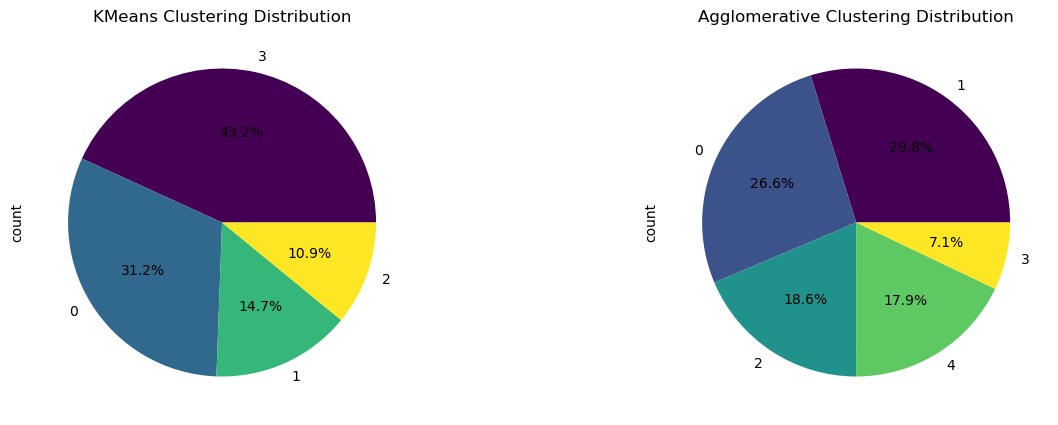

In [119]:
# Plot the piechart of the customer ids per the clusters and agglomerative clusters in subplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', cmap='viridis')
plt.title('KMeans Clustering Distribution')

plt.subplot(1, 2, 2)
df['Cluster_Agglomerative'].value_counts().plot.pie(autopct='%1.1f%%', cmap='viridis')
plt.title('Agglomerative Clustering Distribution')

plt.show()

In [116]:
# Print the average values from KMeans and Agglomerative Clustering
print('---------------------------------------------------------------------------')
print('KMeans Cluster AVG Summary')
print('---------------------------------------------------------------------------')
print(cluster_avg)
print('---------------------------------------------------------------------------')
print('---------------------------------------------------------------------------')
print('Agglomerative Cluster AVG Summary')
print('---------------------------------------------------------------------------')
print(alg_cluster_avg)
print('---------------------------------------------------------------------------')

---------------------------------------------------------------------------
KMeans Cluster AVG Summary
---------------------------------------------------------------------------
        Recency Frequency  Monetary             L      CLV
           mean      mean      mean  count   mean     mean
Cluster                                                   
0         220.0      23.0    5190.0   8035    0.0    905.0
1         255.0     140.0  250811.0   3770  260.0  13431.0
2          22.0      81.0   85787.0   2812    8.0   7059.0
3         288.0      99.0  133207.0  11110    0.0   8874.0
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Agglomerative Cluster AVG Summary
---------------------------------------------------------------------------
                      Recency Frequency  Monetary            L      CLV
                         mean      mean      mean count   mean     mean
Cl

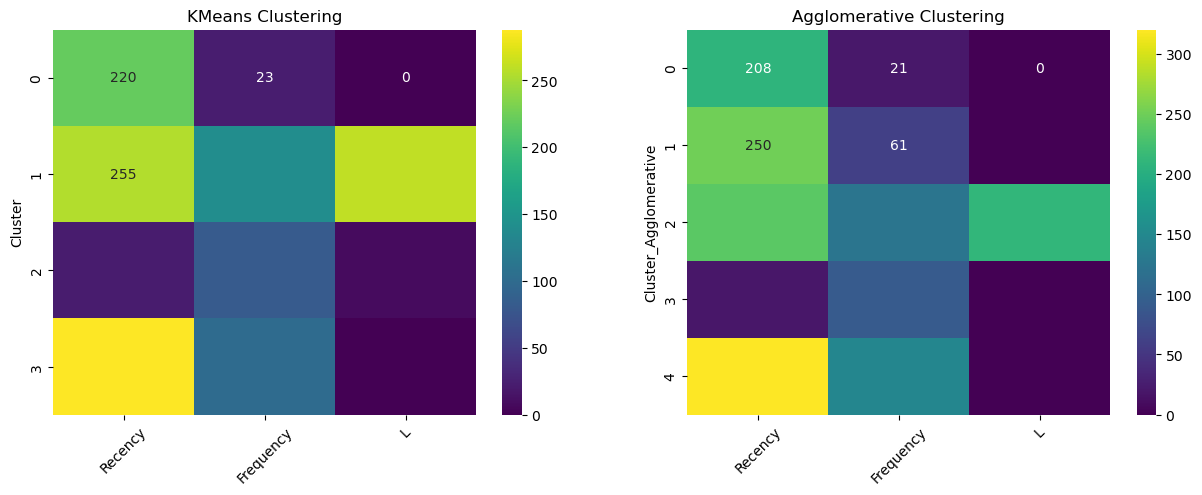

In [108]:
# Plot a heatmap of cluster_avg - the average values of the columns per cluster
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# Rotate the x-axis labels
plt.xticks(rotation=45)
sns.heatmap(cluster_avg[['Recency', 'Frequency', 'L']], annot=True, fmt='.0f', cmap='viridis')
plt.title('KMeans Clustering')

plt.subplot(1, 2, 2)
# Rotate the x-axis labels
plt.xticks(rotation=45)
sns.heatmap(alg_cluster_avg[['Recency', 'Frequency', 'L']], annot=True, fmt='.0f', cmap='viridis')
plt.title('Agglomerative Clustering')

plt.show()

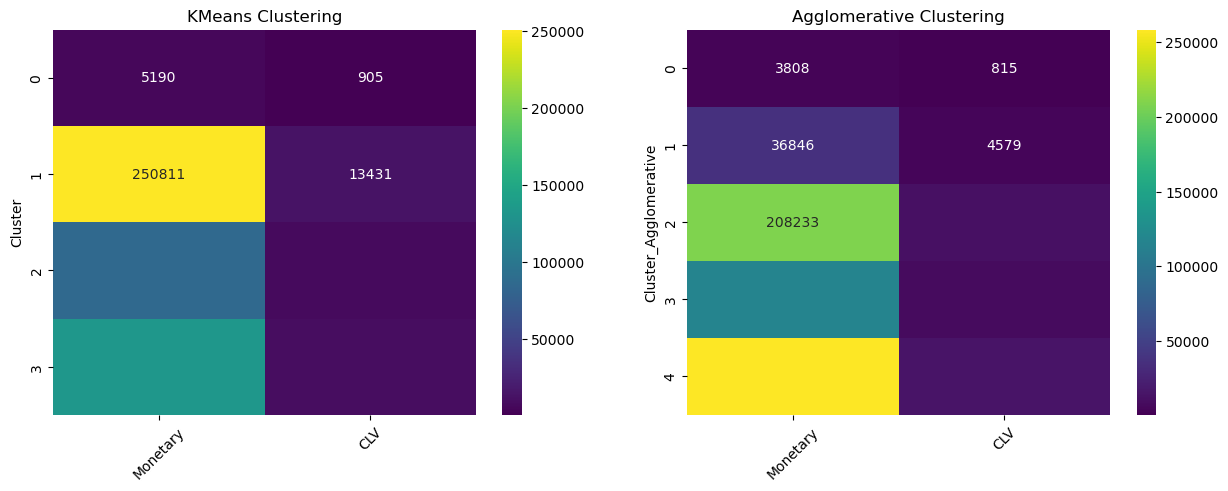

In [109]:
# Plot a heatmap of cluster_avg - the average values of the columns per cluster
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# Rotate the x-axis labels
plt.xticks(rotation=45)
sns.heatmap(cluster_avg[['Monetary', 'CLV']], annot=True, fmt='.0f', cmap='viridis')
plt.title('KMeans Clustering')

plt.subplot(1, 2, 2)
# Rotate the x-axis labels
plt.xticks(rotation=45)
sns.heatmap(alg_cluster_avg[['Monetary', 'CLV']], annot=True, fmt='.0f', cmap='viridis')
plt.title('Agglomerative Clustering')

plt.show()